In [4]:
%%capture
!pip -q install pymupdf nltk pandas tqdm faiss-cpu   sentence-transformers transformers accelerate torch   sacrebleu rouge-score gradio hf_transfer evaluate

In [3]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/hcv_rag_template"  # change if you use /hcv_rag
import os, sys
os.environ["HF_HOME"] = "/content/drive/MyDrive/hf_cache"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
sys.path.append(BASE_DIR)
from pathlib import Path
BASE = Path(BASE_DIR)
DATA = BASE / "data"
GUIDELINES = DATA / "guidelines"
ARTIFACTS = BASE / "artifacts"
OUTPUTS = BASE / "outputs"
for p in [DATA, GUIDELINES, ARTIFACTS, OUTPUTS]:
    p.mkdir(parents=True, exist_ok=True)
print("Using BASE_DIR:", BASE_DIR)
print("Expect PDFs in:", GUIDELINES)

Mounted at /content/drive
Using BASE_DIR: /content/drive/MyDrive/hcv_rag_template
Expect PDFs in: /content/drive/MyDrive/hcv_rag_template/data/guidelines


In [5]:
import fitz  # PyMuPDF
import pandas as pd
from nltk import sent_tokenize
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
CHUNK_SIZE = 400
CHUNK_OVERLAP = 80
def extract_text_from_pdfs(input_dir: Path, output_dir: Path):
    output_dir.mkdir(parents=True, exist_ok=True)
    txt_files = []
    for pdf in sorted(input_dir.glob("*.pdf")):
        doc = fitz.open(pdf)
        full = []
        for page in doc:
            full.append(page.get_text())
        out = output_dir / f"{pdf.stem}.txt"
        out.write_text("\n".join(full), encoding="utf-8")
        txt_files.append(out)
    return txt_files
def clean_text(s: str) -> str:
    lines = [ln.strip() for ln in s.splitlines() if ln.strip()]
    return " ".join(lines)
def chunk_text(text: str, chunk_size: int = CHUNK_SIZE, overlap: int = CHUNK_OVERLAP):
    sents = sent_tokenize(text)
    chunks, cur = [], ""
    for s in sents:
        if len(cur) + len(s) <= chunk_size:
            cur += " " + s
        else:
            chunks.append(cur.strip())
            cur = " ".join(cur.split()[-overlap:]) + " " + s
    if cur.strip():
        chunks.append(cur.strip())
    return chunks
def ensure_artifacts():
    """Create artifacts/chunks.csv if missing (idempotent)."""
    chunks_csv = ARTIFACTS / "chunks.csv"
    if chunks_csv.exists():
        print("✓ chunks.csv exists:", chunks_csv)
        return chunks_csv
    assert any(GUIDELINES.glob("*.pdf")), f"No PDFs found in {GUIDELINES}. Put EASL/AASLD PDFs there."
    txt_files = extract_text_from_pdfs(GUIDELINES, GUIDELINES)
    cleaned_files = []
    for txt in txt_files:
        raw = txt.read_text(encoding="utf-8")
        cleaned = clean_text(raw)
        out = txt.with_name(txt.stem + "_cleaned.txt")
        out.write_text(cleaned, encoding="utf-8")
        cleaned_files.append(out)
    rows = []
    for cf in cleaned_files:
        t = cf.read_text(encoding="utf-8")
        for i, ch in enumerate(chunk_text(t)):
            rows.append({"source": cf.name, "chunk_id": i, "text": ch})
    df = pd.DataFrame(rows)
    df.to_csv(chunks_csv, index=False)
    print("✓ wrote", chunks_csv, "| rows:", len(df))
    return chunks_csv
chunks_csv = ensure_artifacts()

✓ chunks.csv exists: /content/drive/MyDrive/hcv_rag_template/artifacts/chunks.csv


In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np, faiss
QA_EMBEDDER_ID = "multi-qa-MiniLM-L6-cos-v1"  # good for Q/A retrieval
qa_embedder = SentenceTransformer(QA_EMBEDDER_ID)
def load_chunks(path: Path):
    return pd.read_csv(path)
def build_or_load_index(df_chunks: pd.DataFrame):
    idx_path = ARTIFACTS / "faiss.index"
    emb_path = ARTIFACTS / "embeddings.npy"
    if idx_path.exists() and emb_path.exists():
        index = faiss.read_index(str(idx_path))
        print("✓ loaded FAISS index:", idx_path)
        return index
    texts = df_chunks["text"].tolist()
    X = qa_embedder.encode(texts, convert_to_numpy=True, show_progress_bar=True)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)  # normalize for cosine
    index = faiss.IndexFlatIP(X.shape[1])
    index.add(X)
    faiss.write_index(index, str(idx_path))
    np.save(str(emb_path), X)
    print("✓ built FAISS index:", idx_path, "| ntotal:", index.ntotal)
    return index
df_chunks = load_chunks(chunks_csv)
index = build_or_load_index(df_chunks)
def search_cosine(query: str, top_k: int = 3):
    qv = qa_embedder.encode([query], convert_to_numpy=True)
    qv = qv / np.linalg.norm(qv, axis=1, keepdims=True)
    D, I = index.search(qv, top_k)
    rows = df_chunks.iloc[I[0]].copy()
    rows["rank"] = range(1, len(rows)+1)
    return rows, D[0], I[0]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ loaded FAISS index: /content/drive/MyDrive/hcv_rag_template/artifacts/faiss.index


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
device = 0 if torch.cuda.is_available() else -1
def load_generator():
    model_name = "google/flan-t5-large" if device == 0 else "google/flan-t5-base"
    tok = AutoTokenizer.from_pretrained(model_name)
    dtype = torch.float16 if device == 0 else torch.float32
    mdl = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=dtype)
    gen = pipeline("text2text-generation", model=mdl, tokenizer=tok, device=device)
    print("✓ generator:", model_name, "| device:", "GPU" if device==0 else "CPU")
    return gen
RAG_PROMPT = """You are a clinical question-answering assistant.
Answer ONLY using the information in the CONTEXT. If none of the retrieved snippets contain the answer, say:
"Not enough evidence in the provided guidelines."

Guidance:
- If at least one snippet partially answers the question, synthesize a concise, factual answer from those snippets.
- Prefer bullet points where helpful.
- Include citations like [source: <file>, chunk: <id>] after the statements they support.
- Do NOT invent facts or medications not present in the context.

QUESTION:
{question}

CONTEXT:
{context}

Now answer grounded ONLY in the context above.
"""
def build_context(rows, max_chars=3500):
    parts, total = [], 0
    for _, r in rows.iterrows():
        block = f"[rank {r['rank']}] [source: {r['source']} | chunk: {r['chunk_id']}]\n{r['text']}\n"
        if total + len(block) <= max_chars:
            parts.append(block); total += len(block)
        else:
            break
    return "\n".join(parts)
gen = load_generator()
def rag_answer(question: str, rows, max_new_tokens=256, temperature=0.0):
    ctx = build_context(rows, max_chars=3500)
    prompt = RAG_PROMPT.format(question=question, context=ctx)
    out = gen(prompt,
              max_new_tokens=max_new_tokens,
              do_sample=(temperature>0.0),
              temperature=temperature,
              num_beams=4 if temperature==0.0 else 1)[0]["generated_text"]
    return out
def rag_fn(question: str, top_k: int = 3):
    rows, D, I = search_cosine(question, top_k=top_k)
    ans = rag_answer(question, rows, max_new_tokens=256, temperature=0.0)
    return ans, rows

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Device set to use cpu


✓ generator: google/flan-t5-base | device: CPU


In [8]:
import unicodedata, re
from nltk import sent_tokenize
from rouge_score import rouge_scorer
from sentence_transformers import util
from transformers import AutoTokenizer, AutoModelForSequenceClassification
NLI_ID = "facebook/bart-large-mnli"
nli_tok = AutoTokenizer.from_pretrained(NLI_ID)
nli_model = AutoModelForSequenceClassification.from_pretrained(NLI_ID).to("cuda" if torch.cuda.is_available() else "cpu")
nli_model.eval()
print("✓ NLI:", NLI_ID)
_LMAP = {"ﬁ":"fi","ﬂ":"fl","ﬀ":"ff","ﬃ":"ffi","ﬄ":"ffl","ﬅ":"ft","ﬆ":"st",
         "–":"-","—":"-","−":"-","•":"*","’":"'", "“":'"', "”":'"'}
def _clean(s: str) -> str:
    if not isinstance(s, str): s = str(s or "")
    s = unicodedata.normalize("NFKC", s)
    for k,v in _LMAP.items(): s = s.replace(k,v)
    return re.sub(r"\s+"," ", s).strip()
def entailment_prob(premise: str, hypothesis: str, max_len=512) -> float:
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = nli_tok(_clean(premise), _clean(hypothesis), return_tensors="pt",
                     truncation=True, max_length=max_len, padding=True).to(dev)
    with torch.no_grad():
        logits = nli_model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].tolist()  # [contradiction, neutral, entailment]
    return float(probs[2])
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
SBERT_ID = "all-MiniLM-L6-v2"
sbert = SentenceTransformer(SBERT_ID)
def rouge_recall(s, ctx): return rouge.score(s, ctx)['rougeL'].recall
def max_sem_sim(sent, ctx_texts):
    if not ctx_texts: return 0.0
    with torch.no_grad():
        s = sbert.encode([sent], convert_to_tensor=True, normalize_embeddings=True)
        C = sbert.encode(ctx_texts, convert_to_tensor=True, normalize_embeddings=True)
        sims = util.cos_sim(s, C).cpu().numpy()[0]
    return float(sims.max())
NLI_THRESH   = 0.6
ROUGE_HIGH   = 0.90
ROUGE_THRESH = 0.50
SIM_THRESH   = 0.60
ABSTAIN_TEXT = "Not enough evidence in the provided guidelines."
def grounded_fraction_robust(answer: str, rows_df, nli_thresh=NLI_THRESH,
                             rouge_high=ROUGE_HIGH, rouge_thresh=ROUGE_THRESH, sim_thresh=SIM_THRESH):
    ctxs = rows_df["text"].tolist() if len(rows_df) else []
    sents = [s for s in sent_tokenize(answer) if s.strip()]
    if not sents or not ctxs:
        return 0.0, []
    details, grounded = [], []
    for s in sents:
        nli_best   = max(entailment_prob(premise=txt, hypothesis=s) for txt in ctxs)
        rouge_best = max(rouge_recall(s, txt) for txt in ctxs)
        sim_best   = max_sem_sim(s, ctxs)
        g = (nli_best >= nli_thresh) or (rouge_best >= rouge_high) or (rouge_best >= rouge_thresh and sim_best >= sim_thresh)
        details.append({"sent": s, "nli_best": round(nli_best,3),
                        "rouge_best": round(rouge_best,3), "sim_best": round(sim_best,3), "grounded": g})
        grounded.append(g)
    return sum(grounded)/len(grounded), details

✓ NLI: facebook/bart-large-mnli


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

In [9]:
import evaluate, sacrebleu
import numpy as np

rouge_eval = evaluate.load("rouge")

def text_numbers(s: str):
    return set(re.findall(r"\b\d+(?:\.\d+)?(?:\s*[-–]\s*\d+(?:\.\d+)?)?%?\b", s or ""))

def numbers_clean(ans: str, rows_df) -> bool:
    ctx = " ".join(rows_df["text"].tolist())
    return len(text_numbers(ans) - text_numbers(ctx)) == 0

def run_eval_robust(df_eval: pd.DataFrame, top_k: int = 3, nli_thresh=NLI_THRESH):
    rows = []
    for _, r in df_eval.iterrows():
        q = str(r["question"])
        ref = str(r.get("reference_answer","") or "")
        ans, rows_df = rag_fn(q, top_k=top_k)
        gf, _ = grounded_fraction_robust(ans, rows_df, nli_thresh=nli_thresh)
        rougeL = rouge_eval.compute(predictions=[ans], references=[ref]).get("rougeL", np.nan) if ref else np.nan
        bleu   = sacrebleu.corpus_bleu([ans], [[ref]]).score if ref else np.nan
        passed = (gf >= nli_thresh) and numbers_clean(ans, rows_df)
        rows.append({"question": q, "grounded_frac": gf, "rougeL": rougeL, "bleu": bleu, "pass_eval": passed, "answer_preview": ans[:220]})
    return pd.DataFrame(rows)

In [10]:
q = "What monitoring is recommended before initiating HCV therapy?"
ans, rows_df = rag_fn(q, top_k=3)
gf, details = grounded_fraction_robust(ans, rows_df, nli_thresh=NLI_THRESH)
print("QUESTION:", q)
print("ANSWER (preview):", ans[:300], "..." if len(ans)>300 else "")
print("Grounded fraction:", round(gf,3))
pd.DataFrame(details).head(10)

Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


QUESTION: What monitoring is recommended before initiating HCV therapy?
ANSWER (preview): Treatment monitoring Treatment monitoring includes monitoring of treatment efficacy, of safety and side effects, and of drug-drug interactions. Assessment of treatment efficacy Minimal monitoring is now required to assess treatment efficacy, except in populations at risk of poor adherence to treatme ...
Grounded fraction: 1.0


,sent,nli_best,rouge_best,sim_best,grounded
0,Treatment monitoring Treatment monitoring incl...,0.891,0.947,0.498,True
1,Assessment of treatment efficacy Minimal monit...,0.486,0.913,0.451,True
2,"In all cases, HCV RNA or HCV core antigen asse...",0.776,1.000,0.687,True


In [11]:
eval_csv = BASE / "eval_questions.csv"
if not eval_csv.exists():
    starter = pd.DataFrame([
        {"question": "What monitoring is recommended before initiating HCV therapy?", "reference_answer": "Add a short guideline-grounded reference answer here."},
        {"question": "What is recommended after SVR in patients with cirrhosis?", "reference_answer": "Add a short guideline-grounded reference answer here."},
    ])
    starter.to_csv(eval_csv, index=False)
    print("✓ Created starter eval set at:", eval_csv)
else:
    print("✓ Found eval set:", eval_csv)

df_eval = pd.read_csv(eval_csv)

grid = []
for t in [0.6, 0.65, 0.7, 0.75, 0.8]:
    rep = run_eval_robust(df_eval, top_k=3, nli_thresh=t)
    grid.append({
        "threshold": t,
        "pass_rate": float(rep["pass_eval"].mean()),
        "avg_grounded_frac": float(rep["grounded_frac"].mean(skipna=True)),
        "avg_rougeL": float(rep["rougeL"].mean(skipna=True))
    })
pd.DataFrame(grid)

✓ Found eval set: /content/drive/MyDrive/hcv_rag_template/eval_questions.csv


,threshold,pass_rate,avg_grounded_frac,avg_rougeL
0,0.60,1.0,1.0,NaN
1,0.65,1.0,1.0,NaN
2,0.70,1.0,1.0,NaN
3,0.75,1.0,1.0,NaN
4,0.80,1.0,1.0,NaN


In [12]:
!pip install openpyxl

import pandas as pd
from pathlib import Path
BASE_DIR = "/content/drive/MyDrive/hcv_rag_template"
df_eval = pd.read_excel("/content/drive/MyDrive/hcv_rag_template/eval_questions.xlsx")
print("Rows:", len(df_eval))
print("Pct with reference_answer filled:")
rep = run_eval_robust(df_eval, top_k=3, nli_thresh=0.6)
rep["grounded_frac"].describe()
rep[["question","grounded_frac","answer_preview"]].head(5)

Rows: 20
Pct with reference_answer filled:


,question,grounded_frac,answer_preview
0,What laboratory tests are required before init...,1.000,"6 months, testing for HCV RNA or follow-up tes..."
1,What fibrosis assessment is recommended before...,0.875,Fibrosis stage must initially be assessed by n...
2,What are the recommended DAA options for treat...,1.000,Moderate P-gp or CYP inducers (such as modafin...
3,What additional monitoring is required for pat...,1.000,Ultrasound surveillance for HCC (with or witho...
4,What are contraindications to glecaprevir/pibr...,0.000,Not enough evidence in the provided guidelines.


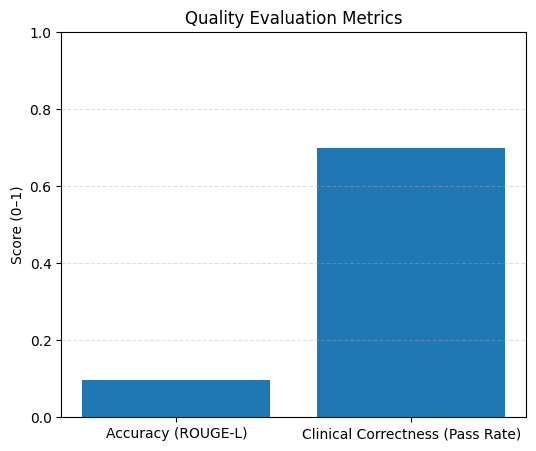

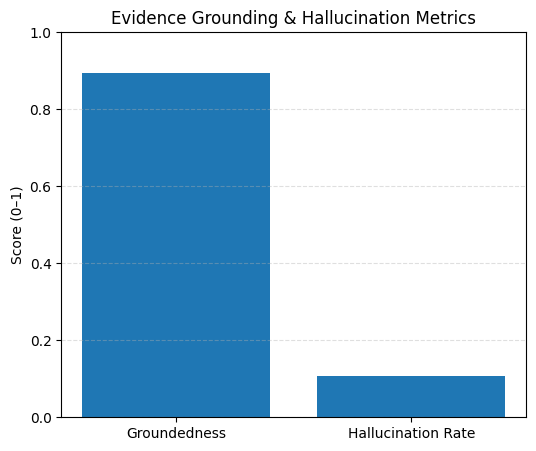

In [13]:
import matplotlib.pyplot as plt
import numpy as np

avg_rougeL = rep["rougeL"].mean(skipna=True)
pass_rate  = rep["pass_eval"].mean()
grounded   = rep["grounded_frac"].mean()
halluc_rate = 1 - grounded
plt.figure(figsize=(6,5))
metrics1 = [avg_rougeL, pass_rate]
labels1  = ["Accuracy (ROUGE-L)", "Clinical Correctness (Pass Rate)"]
plt.bar(labels1, metrics1)
plt.ylim(0,1)
plt.title("Quality Evaluation Metrics")
plt.ylabel("Score (0–1)")
plt.grid(axis='y', linestyle="--", alpha=0.4)
plt.show()
plt.figure(figsize=(6,5))
metrics2 = [grounded, halluc_rate]
labels2  = ["Groundedness", "Hallucination Rate"]
plt.bar(labels2, metrics2)
plt.ylim(0,1)
plt.title("Evidence Grounding & Hallucination Metrics")
plt.ylabel("Score (0–1)")
plt.grid(axis='y', linestyle="--", alpha=0.4)
plt.show()

In [14]:
import re
import pandas as pd
import numpy as np

def evaluate_answer(question, reference, answer, rows_df, nli_thresh=0.6):
    grounded_frac, details = grounded_fraction_robust(answer, rows_df, nli_thresh=nli_thresh)
    hallucination_rate = 1 - grounded_frac
    numbers_ok = numbers_clean(answer, rows_df)
    clinical_correct = int((grounded_frac >= nli_thresh) and numbers_ok)
    try:
        rougeL = rouge_eval.compute(predictions=[answer], references=[reference]).get("rougeL", np.nan)
    except:
        rougeL = np.nan

    try:
        bleu = sacrebleu.corpus_bleu([answer], [[reference]]).score
    except:
        bleu = np.nan
    citation_tags = len(re.findall(r"\[source:", answer))
    sentences = [s for s in answer.split('.') if s.strip()]
    citation_quality = citation_tags / max(1, len(sentences))
    example_score = (
        0.35 * grounded_frac +
        0.25 * clinical_correct +
        0.20 * (1 - hallucination_rate) +
        0.20 * citation_quality
    )
    return {
        "question": question,
        "rougeL": rougeL,
        "bleu": bleu,
        "grounded_frac": grounded_frac,
        "hallucination_rate": hallucination_rate,
        "clinical_correct": clinical_correct,
        "citation_quality": citation_quality,
        "example_score": example_score,
        "answer_preview": answer[:200]
    }
def run_full_evaluation(df_eval, top_k=3, nli_thresh=0.6):
    all_rows = []
    for _, row in df_eval.iterrows():
        q = row["question"]
        ref = row["reference_answer"]
        answer, rows_df = rag_fn(q, top_k=top_k)
        metrics = evaluate_answer(
            question=q,
            reference=ref,
            answer=answer,
            rows_df=rows_df,
            nli_thresh=nli_thresh
        )
        all_rows.append(metrics)
    return pd.DataFrame(all_rows)

In [15]:
df_results = run_full_evaluation(df_eval, top_k=3, nli_thresh=0.6)
df_results

,question,rougeL,bleu,grounded_frac,hallucination_rate,clinical_correct,citation_quality,example_score,answer_preview
0,What laboratory tests are required before init...,0.063492,0.971231,1.000,0.000,1,0.000000,0.800000,"6 months, testing for HCV RNA or follow-up tes..."
1,What fibrosis assessment is recommended before...,0.120482,0.640772,0.875,0.125,0,0.111111,0.503472,Fibrosis stage must initially be assessed by n...
2,What are the recommended DAA options for treat...,0.038217,0.337827,1.000,0.000,0,0.000000,0.550000,Moderate P-gp or CYP inducers (such as modafin...
3,What additional monitoring is required for pat...,0.125000,1.368537,1.000,0.000,1,0.000000,0.800000,Ultrasound surveillance for HCC (with or witho...
4,What are contraindications to glecaprevir/pibr...,0.076923,1.141221,0.000,1.000,0,0.000000,0.000000,Not enough evidence in the provided guidelines.
5,How should HCV therapy be managed in patients ...,0.266667,2.145638,1.000,0.000,1,0.000000,0.800000,"HBsAg, anti-HBs, and anti-HBc testing."
6,What drug–drug interactions must be checked be...,0.111111,1.662306,1.000,0.000,1,0.000000,0.800000,a full and detailed drug history should be tak...
7,When should HCV RNA be checked during therapy?,0.145455,1.014725,1.000,0.000,1,0.000000,0.800000,Routine testing for HCV RNA during treatment i...
8,How is sustained virologic response (SVR12) de...,0.074074,1.104628,1.000,0.000,1,0.000000,0.800000,"SVR12 rate was 96% in both arms, 106/110 of pa..."
9,What follow-up is needed for non-cirrhotic pat...,0.080000,0.993530,1.000,0.000,1,0.000000,0.800000,Ultrasound surveillance for HCC (with or witho...


In [16]:
summary = df_results.mean(numeric_only=True)
summary

,0
rougeL,0.096641
bleu,1.419150
grounded_frac,0.893750
hallucination_rate,0.106250
clinical_correct,0.700000
citation_quality,0.021806
example_score,0.670924


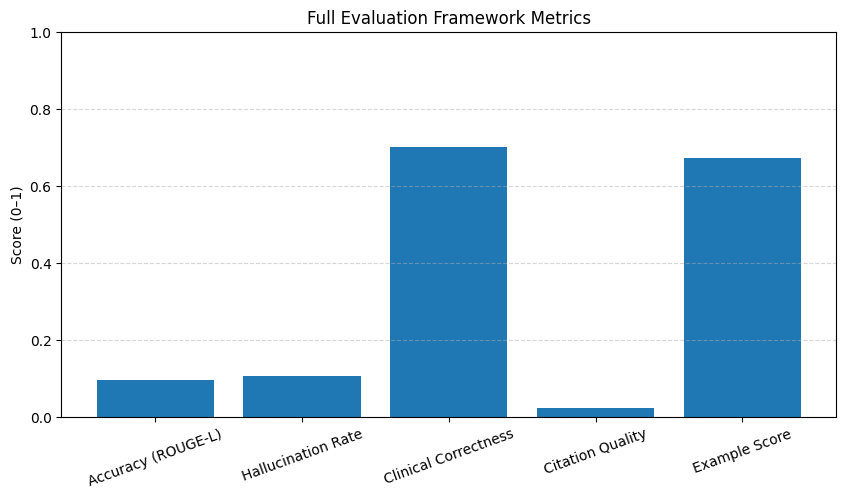

In [17]:
import matplotlib.pyplot as plt

metrics = [
    summary["rougeL"],
    summary["hallucination_rate"],
    summary["clinical_correct"],
    summary["citation_quality"],
    summary["example_score"]
]

labels = [
    "Accuracy (ROUGE-L)",
    "Hallucination Rate",
    "Clinical Correctness",
    "Citation Quality",
    "Example Score"
]

plt.figure(figsize=(10,5))
plt.bar(labels, metrics)
plt.ylim(0,1)
plt.title("Full Evaluation Framework Metrics")
plt.ylabel("Score (0–1)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [18]:
!pip install gradio --quiet
import gradio as gr
import pandas as pd
def rag_gradio(query, top_k):
    if not query.strip():
        return "Please enter a question.", ""
    answer, rows_df = rag_fn(query, top_k=int(top_k))
    retrieved_text = ""
    for _, row in rows_df.iterrows():
        retrieved_text += f"🔹 **Rank {row['rank']}** — {row['source']} (chunk {row['chunk_id']})\n"
        retrieved_text += f"{row['text']}\n\n"
    return answer, retrieved_text
with gr.Blocks() as demo:
    gr.Markdown("""
    # 🧬 **HCV RAG Clinical Assistant**
    Enter a clinical question related to **HCV guidelines**, and this assistant will:
    - Retrieve top-k guideline chunks
    - Generate a grounded answer using FLAN-T5
    - Show all evidence retrieved
    """)
    with gr.Row():
        with gr.Column(scale=1):
            q_box = gr.Textbox(
                label="Enter your Clinical Question",
                placeholder="e.g., What monitoring is recommended before initiating HCV therapy?",
                lines=3,
            )
            k_slider = gr.Slider(1, 5, value=3, step=1, label="Top-K Retrieved Chunks")
            submit_btn = gr.Button("Generate Answer")
        with gr.Column(scale=2):
            answer_box = gr.Textbox(
                label="Generated Answer",
                lines=10
            )
    gr.Markdown("### 📄 Retrieved Evidence (FAISS Search Results)")
    retrieved_box = gr.Textbox(
        label="Retrieved Context Snippets",
        lines=12
    )
    submit_btn.click(
        rag_gradio,
        inputs=[q_box, k_slider],
        outputs=[answer_box, retrieved_box]
    )
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


<IPython.core.display.Javascript object>